This tutorial introduces the scCausalVI model and demonstrates its application with interferon-beta-stimulated PBMC scRNA-seq data.

In [1]:
import os
import scanpy as sc
import scvi
import anndata as ad
import numpy as np
import pandas as pd
from scCausalVI import scCausalVIModel
import gdown
import torch

import seaborn as sns
import matplotlib.pyplot as plt

scvi.settings.seed = 0


Seed set to 0


In [2]:
ifnb_id = '1Im52_rfWWOzsINCETN-ObIJZRU5JFF_D'
url = f"https://drive.google.com/uc?id={ifnb_id}"
data_path = 'ifnb.h5ad'
gdown.download(url, data_path, quiet=False)

In [3]:
adata = sc.read(data_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 24679 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets'
    var: 'V1', 'V2'

Cellular annotations were stored in adata.obs['cell'] and condition labels in adata.obs['stim']

Filter out cells without valid annotations.

In [5]:
adata = adata[adata.obs['cell'].notna()]

In [6]:
adata

View of AnnData object with n_obs × n_vars = 24673 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets'
    var: 'V1', 'V2'

For users without a GPU, we begin with a smaller, subsampled dataset to enable a quicker demo. If GPU-based training is available, you may skip the subsampling step.

In [7]:
# Subsample data for efficiency if the user is not using a GPU
# Group by the 'stim' column in `adata.obs` and sample 30% of each group
adata_sampled = adata[adata.obs.groupby('stim', group_keys=False).apply(lambda x: x.sample(frac=0.3)).index]

# Verify the sample proportions are consistent
print(f"Before subsample:\n {adata.obs['stim'].value_counts(normalize=True)}\n")
print(f"After subsample:\n {adata_sampled.obs['stim'].value_counts(normalize=True)}")


adata = adata_sampled

Before subsample:
 stim
stim    0.500871
ctrl    0.499129
Name: proportion, dtype: float64

After subsample:
 stim
stim    0.500878
ctrl    0.499122
Name: proportion, dtype: float64


In [8]:
condition_key = 'stim'
group_key = 'cell'
n_conditions = len(adata.obs[condition_key].unique())
print(f"Number of conditions: {n_conditions}")

Number of conditions: 2


## Data Pre-processing
The pre-processing steps include filtering genes and cells, normalizing data, and selecting highly variable genes.
Note that scCausalVI requires raw count data as input, so users should retain the count data prior to normalization.

In [9]:
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_genes(adata, min_cells=100)
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat_v3',
    n_top_genes=1000,
    layer='counts',
    subset=True,
)

In [10]:
adata.obs[condition_key].value_counts()

stim
stim    3703
ctrl    3692
Name: count, dtype: int64

In [11]:
conditions = ['ctrl', 'stim',] 
control_key='ctrl'
group_indices_list = [np.where(adata.obs[condition_key]==group)[0] for group in conditions]
scCausalVIModel.setup_anndata(adata, condition_key=condition_key, layer='counts',)

# For multi-batch data, register batch index of batch_key in obs:
# scCausalVIModel.setup_anndata(adata, batch_key='stim', condition_key=condition_key, layer='counts',)

condition2int = adata.obs.groupby(condition_key, observed=False)['_scvi_condition'].first().to_dict()


In [12]:
print(condition2int)

{'ctrl': 0, 'stim': 1}


In [13]:
model = scCausalVIModel(
    adata, 
    condition2int=condition2int,
    control=control_key,
    n_background_latent=10,
    n_te_latent=10,
    n_layers=2,
    n_hidden=128,
    use_mmd=True,
    mmd_weight=10,
    norm_weight=0.2,
)

In [14]:
use_gpu = torch.cuda.is_available()

model.train(
    group_indices_list,
    use_gpu=use_gpu,
    max_epochs=200,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


accelerator: cpu
Epoch 200/200: 100%|█| 200/200 [10:46:55<00:00,  6.92s/it, v_num=1, train_loss_s

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [10:46:55<00:00, 194.08s/it, v_num=1, train_loss_


## Visualize latent data

First, we explored cellular baseline states and response patterns with latent representations. 
With background latent representations, cells are expected to align according to cell type labels and display a well-mixed distribution across conditions.

In [15]:
adata.obsm['latent_bg'], adata.obsm['latent_t'] = model.get_latent_representation()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


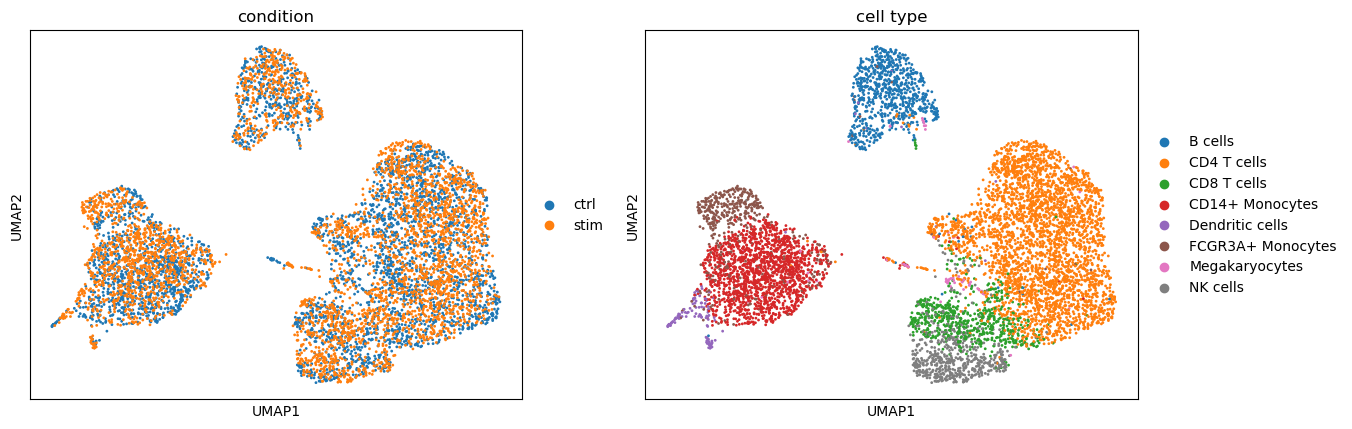

In [16]:
sc.pp.neighbors(adata, use_rep='latent_bg')
sc.tl.umap(adata)
sc.pl.umap(adata, color=[condition_key, group_key], title=['condition', 'cell type'])


With treatment effect latent representations, we can explore differential response patterns. 
It's worthnoting that that the treatment effect latent factors of control data are all set to 0, denoting the lack of treatment effects in unperturbed cohort.
In the following analyses, we extracted treated cells and visualized their response pattern.

In [17]:
adata_tm = adata[adata.obs[condition_key]=='stim'].copy()

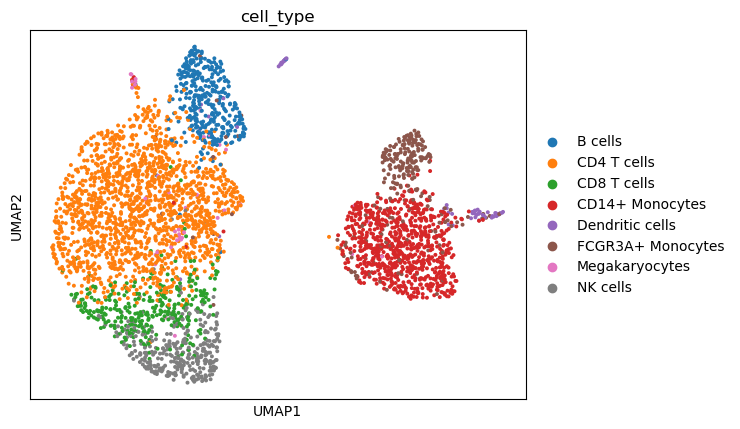

In [18]:
sc.pp.neighbors(adata_tm, use_rep='latent_t')
sc.tl.umap(adata_tm)
sc.pl.umap(adata_tm, color=group_key, title='cell_type')

We quantified the treatment effect size by calculating the L2-norm of the treatment effect latent factors for each cell. This metric indicates the magnitude of each cell’s response to treatment. By grouping cells by annotation labels, we can assess the responsiveness of each cell type.

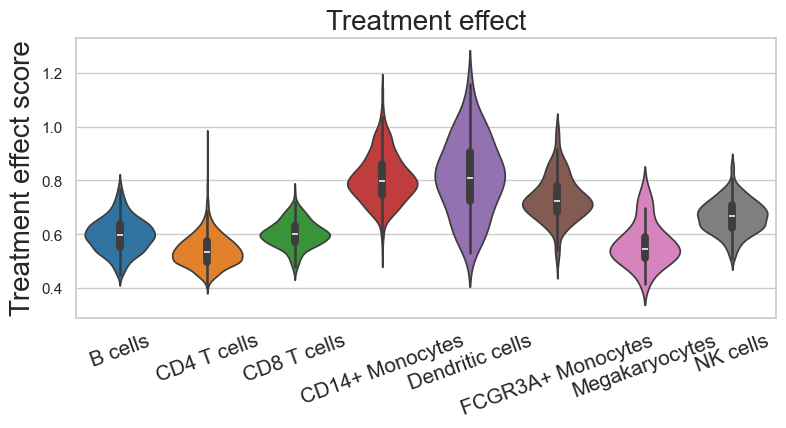

In [19]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 4),)
te = ad.AnnData(
    X=adata_tm.obsm['latent_t'].copy(),
    obs=adata_tm.obs.copy(),
)
te.obs['te'] = np.linalg.norm(te.X, axis=1)

palette = adata_tm.uns['cell_colors']

# sc.pl.violin(te, keys='te', groupby='cell', rotation=20, show=False, ax=ax, palette='Set2')
sns.violinplot(data=te.obs, x='cell', y='te', ax=ax, palette=palette)

ax.set_ylabel('Treatment effect score', fontsize=20)
ax.set_xlabel('')
ax.set_title('Treatment effect', fontsize=20)
ax.tick_params(axis='x', labelsize=15, rotation=20)

plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.2)


The distribution of treatment effect scores across cell types displayed that the dendritic cells and monocytes exhibit notably higher median effect scores, suggesting these populations undergo more pronounced transcriptional changes in response to treatment. It is worthing noting that while other cell types (B cells, CD4 T cells, CD8 T cells, megakaryocytes, and NK cells) show comparatively lower effect scores, this does not necessarily indicate a lack of response. Also, the scores are not directly comparable across different experimental contexts. Instead, we developed a statistical framework using factual and cross-condition predictions of gene expression profiles to rigorously identify responsive cells. 
Overall, treatment effect scores provide a qualitative comparison of response patterns across cell type groups.

## Prediction accuracy
With the generative framework, scCausalVI enables prediction of cellular states at the individual resolution.
We assessed prediction accuracy qualitatively through visualization.

In [20]:
adata_recon = model.get_count_expression()

In [21]:
# Normalize predicted count data
sc.pp.normalize_total(adata_recon, target_sum=1e6)
sc.pp.log1p(adata_recon)

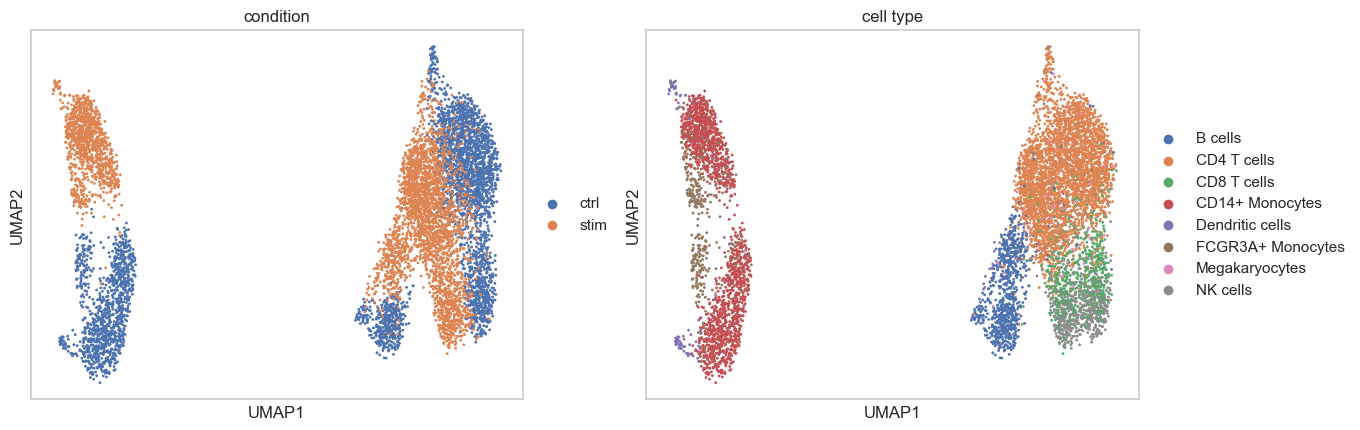

In [22]:
sc.pp.pca(adata_recon,)
sc.pp.neighbors(adata_recon)
sc.tl.umap(adata_recon)

sc.pl.umap(adata_recon, color=[condition_key, group_key,],
           title = ['condition', 'cell type'])

A joint visualization of the predicted and actual data reveals their consistency.

In [23]:
adata.obs['is_real'] = [f'real ' + cond for cond in adata.obs[condition_key]]
adata_recon.obs['is_real'] = [f'pred ' + cond for cond in adata_recon.obs[condition_key]]
adata_recon_real = ad.concat([adata, adata_recon])

In [24]:
sc.pp.pca(adata_recon_real)
sc.pp.neighbors(adata_recon_real)
sc.tl.umap(adata_recon_real)

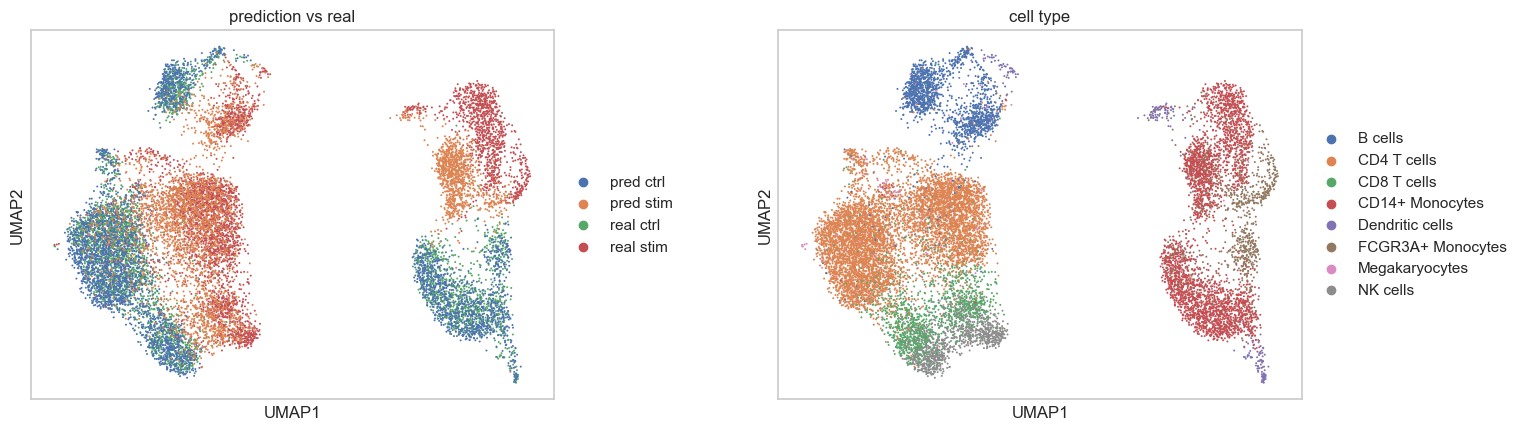

In [25]:
sc.pl.umap(
    adata_recon_real, 
    color = ['is_real', group_key],
    title = ['prediction vs real', 'cell type'],
    wspace=0.3
)

## Cross-condition prediction

The causality-aware generative framework of scCausalVI enables in silico perturbation, allowing prediction of cellular states from a 'source' condition under a 'target' condition at single-cell resolution. 
This cross-condition prediction capability facilitates the measurement of treatment-induced transcriptional changes, enabling 
identification of responsive and non-responsive cells.

As an example, we focus on the stimulated cohort. To perform cross-condition prediction from "source" condition to "target" conditioon, we set source_condition as 'stimulated' and target_condition as 'control'.

In [26]:
adata_cross = model.get_count_expression_cross_condition(
    adata=adata_tm,
    source_condition='stim', 
    target_condition='ctrl',
)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


The target condition was stored in 'predicted_condition' column.

In [27]:
adata_cross.obs

,tsne1,tsne2,ind,stim,cluster,cell,multiplets,n_genes,_scvi_batch,_scvi_condition,predicted_condition,predicted_batch
GCAACTGATTGTCT-1,-10.110025,11.303859,1256,stim,4,B cells,singlet,443,0,1,ctrl,0
CATCTCCTGTTCGA-1,-14.510766,3.676486,1488,stim,4,B cells,singlet,518,0,1,ctrl,0
TTGCATTGGACGTT-1,-13.541178,6.417901,1015,stim,4,B cells,singlet,515,0,1,ctrl,0
TTACTCGATTATCC-1,2.871801,-5.730185,101,stim,3,CD4 T cells,singlet,624,0,1,ctrl,0
AGACACACTCTATC-1,-11.487180,8.903110,107,stim,4,B cells,singlet,411,0,1,ctrl,0
...,...,...,...,...,...,...,...,...,...,...,...,...
TGCGCACTCTTTAC-1,20.292479,13.311756,1488,stim,6,CD4 T cells,singlet,373,0,1,ctrl,0
CGCTAAGAATTCCT-11,-2.541437,-0.928573,101,stim,3,CD4 T cells,singlet,665,0,1,ctrl,0
CTAGGATGCCCTAC-1,22.143948,-11.217506,1015,stim,10,CD8 T cells,singlet,534,0,1,ctrl,0
ATTCTGACACTCAG-1,4.020562,1.385148,1015,stim,6,CD4 T cells,singlet,668,0,1,ctrl,0


In [28]:
sc.pp.normalize_total(adata_cross, target_sum=1e6)
sc.pp.log1p(adata_cross)

Here, we visualized the real control data alongside the in silico control data for evaluation.

In [29]:
adata_ctrl = adata[adata.obs[condition_key] == 'ctrl'].copy()
adata_ctrl.obs['is_real'] = 'real ctrl'
adata_cross.obs['is_real'] = 'stim -> ctrl'

In [30]:
adata_ctrl_joint = ad.concat([adata_ctrl, adata_cross])
sc.pp.pca(adata_ctrl_joint)
sc.pp.neighbors(adata_ctrl_joint)
sc.tl.umap(adata_ctrl_joint)

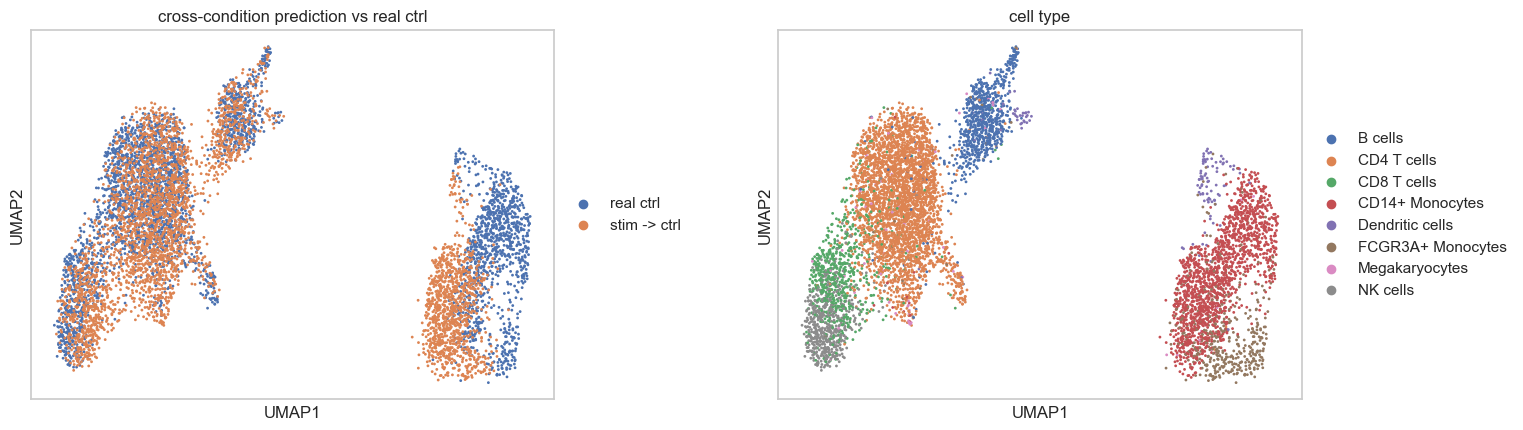

In [31]:
sc.pl.umap(
    adata_ctrl_joint, 
    color = ['is_real', group_key], 
    title = ['cross-condition prediction vs real ctrl', 'cell type'],
    wspace=0.3
)

## Permutation test to identify responsive cells in stimulated cohort

For each treated cell, scCausalVI generates both factual predictions (same condition) and cross-condition predictions (alternative condition). The L2-norm difference between factual predictions and observed profiles establishes a null distribution of generative uncertainty. Responsive cells are identified by comparing the magnitude of treatment-induced changes (difference between observations and cross-condition predictions) against this null distribution.

In this example, we examined the treated (stimulated) cells to identify those responsive to perturbation. Similarly, we can also perform the same analysis on control data to identify susceptible cells that would likely be affected if exposed to the stimulation.

In [32]:
adata_recon = model.get_count_expression(adata_tm)

adata_recon.obs['is_real'] = 'stim -> stim'

sc.pp.normalize_total(adata_recon, target_sum=1e6)
sc.pp.log1p(adata_recon)

We computed the difference on principal components.

In [33]:
from statsmodels.stats.multitest import multipletests

adata_tm.obs['is_real'] = 'real stim'

stim_real_pred = ad.concat([adata_tm, adata_recon, adata_cross])

sc.pp.pca(stim_real_pred, n_comps=20)

diff_null = stim_real_pred[stim_real_pred.obs['is_real'] == "real stim"].obsm['X_pca'] - stim_real_pred[stim_real_pred.obs['is_real'] == "stim -> stim"].obsm['X_pca']

l2_norm_null = np.linalg.norm(diff_null, axis=1)

diff_cf = stim_real_pred[stim_real_pred. obs['is_real'] == "real stim"].obsm['X_pca'] - stim_real_pred[stim_real_pred.obs['is_real'] == "stim -> ctrl"].obsm['X_pca']
l2_norm_cf = np.linalg.norm(diff_cf, axis=1)

# Perform hypothesis testing
# Use the distribution of null hypothesis (l2_norm_null) to test the significance of l2_norm_cf
n = len(diff_null)
p_values = []
for l in l2_norm_cf:
    extreme_count = np.sum(l2_norm_null >= l)
    p_values.append((extreme_count + 1) / (n + 1))

# Apply multi-testing correction (e.g., Benjamini-Hochberg)
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')

significant_cells = np.where(reject)[0]

df = pd.DataFrame({
    "diff_null": l2_norm_null,
    "diff_cf": l2_norm_cf,
})


In [34]:
adata_tm.obs['-log p values'] = -np.log(pvals_corrected +1)
adata_tm.obs['if affected'] = 'False'
adata_tm.obs['if affected'][significant_cells] = 'True'

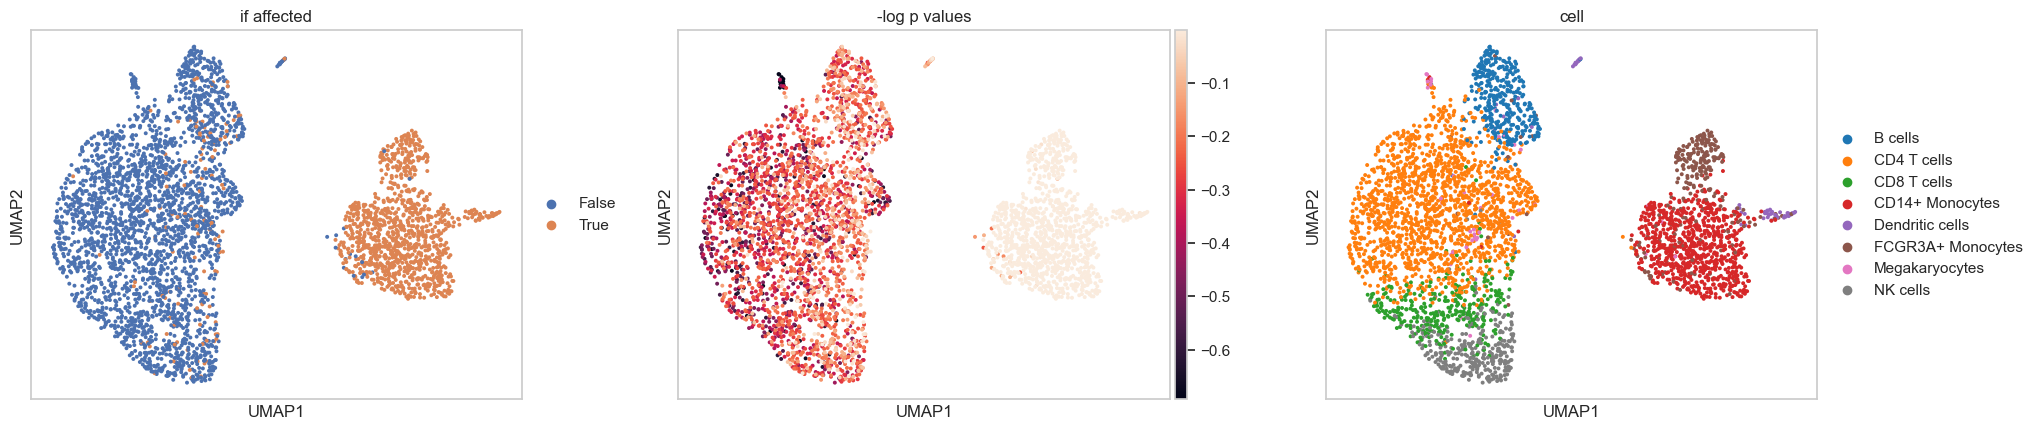

In [35]:
sc.pl.umap(adata_tm, color=['if affected', '-log p values', 'cell'], wspace=0.2)

Besides, the differential response patterns of individual cell type groups can be explored by calculating the proportion of responsive cells. This quantitative analysis revealed consistent conclusions as treatment effect scores that the monocytes and dendritic cells were more responsive compared to other cell types.

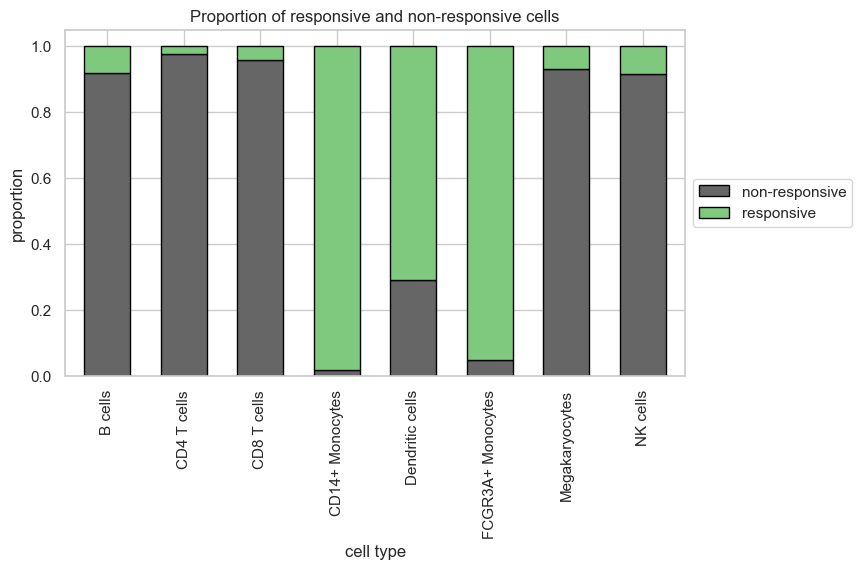

In [36]:
df_prop = adata_tm.obs[['cell', 'if affected']]

# Calculate the proportion of responsive and non-responsive cells for each cell type
proportion_df = df_prop.groupby(['cell', 'if affected']).size().unstack(fill_value=0)
proportion_df = proportion_df.div(proportion_df.sum(axis=1), axis=0)

# Plot the stacked bar chart
proportion_df.plot(kind='bar', stacked=True, colormap='Accent_r', figsize=(8,4.5), 
                   edgecolor='black', width=0.6)

# Add labels and title
plt.xlabel("cell type")
plt.ylabel("proportion")
plt.title("Proportion of responsive and non-responsive cells")
plt.legend(labels=['non-responsive', 'responsive'], 
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## Analyze differential genes between susceptible and resistant cells

By distinguishing between responsive and non-responsive cells, we're able to compare the phenotypic differences to identify potential driver genes. To do this, we conducted an in silico perturbation to predict expression under control conditions for both responsive and non-responsive cells within the stimulated cohort. Analyzing differential expression between these groups helps pinpoint key genes that contribute to each cell type's susceptibility. Here, we use CD8T cells as an example.

In [37]:
resp = adata_tm[adata_tm.obs['if affected'] == 'True'].copy()
resp = resp[resp.obs[group_key] == 'CD8 T cells']
nonresp = adata_tm[adata_tm.obs['if affected'] == 'False'].copy()
nonresp = nonresp[nonresp.obs[group_key] == 'CD8 T cells']

In [38]:
resp_cross = model.get_count_expression_cross_condition(
    source_condition='stim',
    target_condition='ctrl',
    adata=resp
)

nonresp_cross = model.get_count_expression_cross_condition(
    source_condition='stim',
    target_condition='ctrl',
    adata=nonresp
)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [39]:
sc.pp.normalize_total(resp_cross, target_sum=1e6)
sc.pp.log1p(resp_cross)

sc.pp.normalize_total(nonresp_cross, target_sum=1e6)
sc.pp.log1p(nonresp_cross)

resp_cross.obs['source'] = 'susceptible'
nonresp_cross.obs['source'] = 'resistant'

In [40]:
tm_cross = ad.concat([resp_cross, nonresp_cross])
tm_cross.var = resp_cross.var.copy()
tm_cross.var_names = resp_cross.var['V2']



Top genes for resistant:
['APOBEC3G', 'PRF1', 'GZMB', 'HSP90AA1', 'FGFBP2', 'CXCR3', 'DDIT4', 'CTSW', 'LY6E', 'FTH1']

Top genes for susceptible:
['VIM', 'CD63', 'S100A4', 'ANXA5', 'GNLY', 'ACTG1', 'CACYBP', 'HLA-DRB1', 'LGALS1', 'CD27']


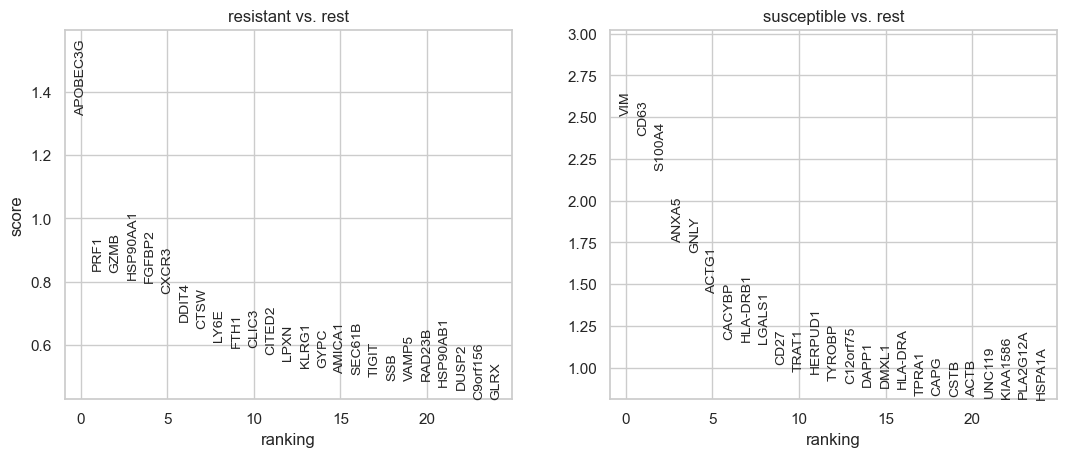

In [41]:
# Perform differential expression analysis
sc.tl.rank_genes_groups(tm_cross, 'source', method='wilcoxon')

# Create the rank_genes_groups plot
sc.pl.rank_genes_groups(tm_cross, n_genes=25, sharey=False, fontsize=10, show=False)

# Get the results
results = tm_cross.uns['rank_genes_groups']
groups = results['names'].dtype.names

# Function to get top differentially expressed genes
def get_top_genes(tm_cross, group, n_top=50):
    """Get top N differentially expressed genes for a group"""
    return [gene for gene in tm_cross.uns['rank_genes_groups']['names'][group][:n_top]]

# Print top differentially expressed genes for each group
for group in groups:
    print(f"\nTop genes for {group}:")
    print(get_top_genes(tm_cross, group, n_top=10))



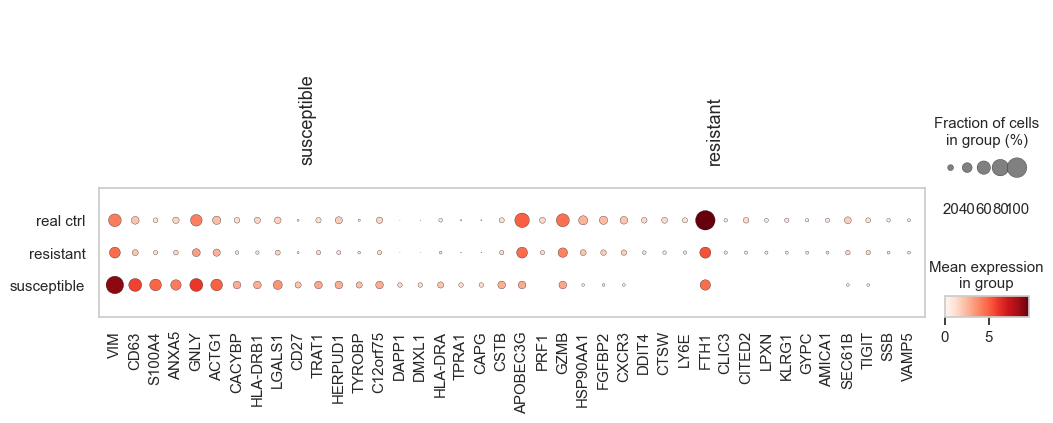

In [42]:
def get_top_genes(tm_cross, group, n_top=50):
    """Get top N differentially expressed genes for a group"""
    return [gene for gene in tm_cross.uns['rank_genes_groups']['names'][group][:n_top]]


plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(figsize=(12, 4))
control_cd8t = adata[(adata.obs[condition_key] == 'ctrl') & (adata.obs[group_key] == 'CD8 T cells')].copy()
control_cd8t.obs['source'] = 'real ctrl'
control_cd8t.var_names = adata.var['V2']
tt = ad.concat([control_cd8t, tm_cross])
markers = {'susceptible': get_top_genes(tm_cross, 'susceptible', n_top=20), 
           'resistant': get_top_genes(tm_cross, 'resistant', n_top=20)}

sc.pl.dotplot(tt, markers, groupby= 'source', show=False, ax=ax,)

plt.show()

The heatmap of differential gene expression analysis between in silico resistant and susceptible cells revealed distinct transcriptional signatures, with resistant cells exhibiting expression patterns similar to control cells, validating their predicted non-responsive phenotype.

## GO term analysis with differentially expressed genes
To explore the functionality of differentially expressed genes in each group, we can apply various functional analysis methods to the collected genes using standard analysis tools. Here, we used GO term analysis as an example.

In [43]:
n_top=25
top_genes_suscep = tm_cross.uns['rank_genes_groups']['names']['susceptible'][:n_top]
top_genes_resist = tm_cross.uns['rank_genes_groups']['names']['resistant'][:n_top]


In [44]:
import requests
import json

def get_enrichr_results(gene_list, database):
    ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(gene_list)
    description = 'Example gene list'
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }
    
    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    
    data = json.loads(response.text)
    user_list_id = data['userListId']
    
    ENRICHR_URL = f'http://maayanlab.cloud/Enrichr/enrich?userListId={user_list_id}&backgroundType={database}'
    response = requests.get(ENRICHR_URL)
    if not response.ok:
        raise Exception('Error fetching enrichment results')
    
    data = json.loads(response.text)
    return pd.DataFrame(data[database], columns=['Rank', 'Term', 'P-value', 'Z-score', 'Combined Score', 'Overlapping Genes', 'Adjusted P-value', 'Old P-value', 'Old Adjusted P-value'])

            

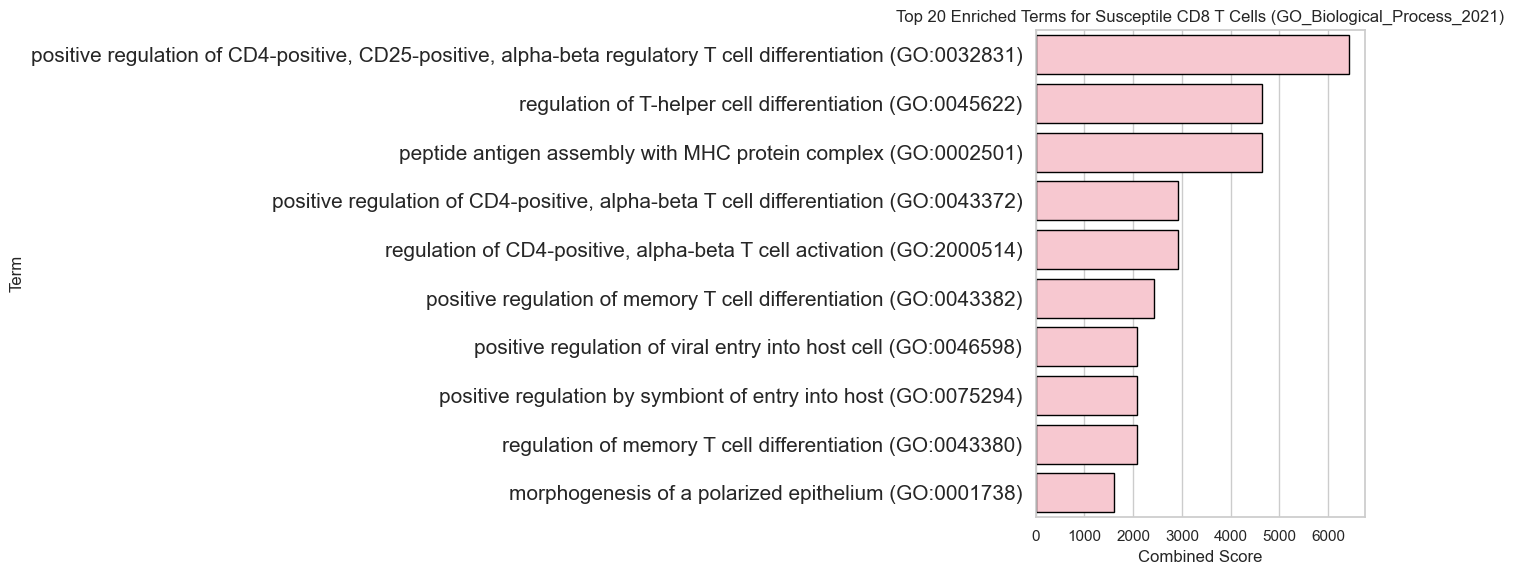

In [45]:

gene_list = top_genes_suscep
database = 'GO_Biological_Process_2021'
results_suscep = get_enrichr_results(gene_list, database)
plt.rcParams.update({'font.size': 15})

# results_aff = get_enrichr_results(gene_list, database)
results_suscep.sort_values(by='Combined Score', inplace=True, ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x='Combined Score', y='Term', data=results_suscep.head(10), edgecolor='black', color='pink',)
plt.title(f'Top 20 Enriched Terms for Susceptile CD8 T Cells ({database})')
plt.yticks(fontsize=15) 
plt.tight_layout()
plt.show()


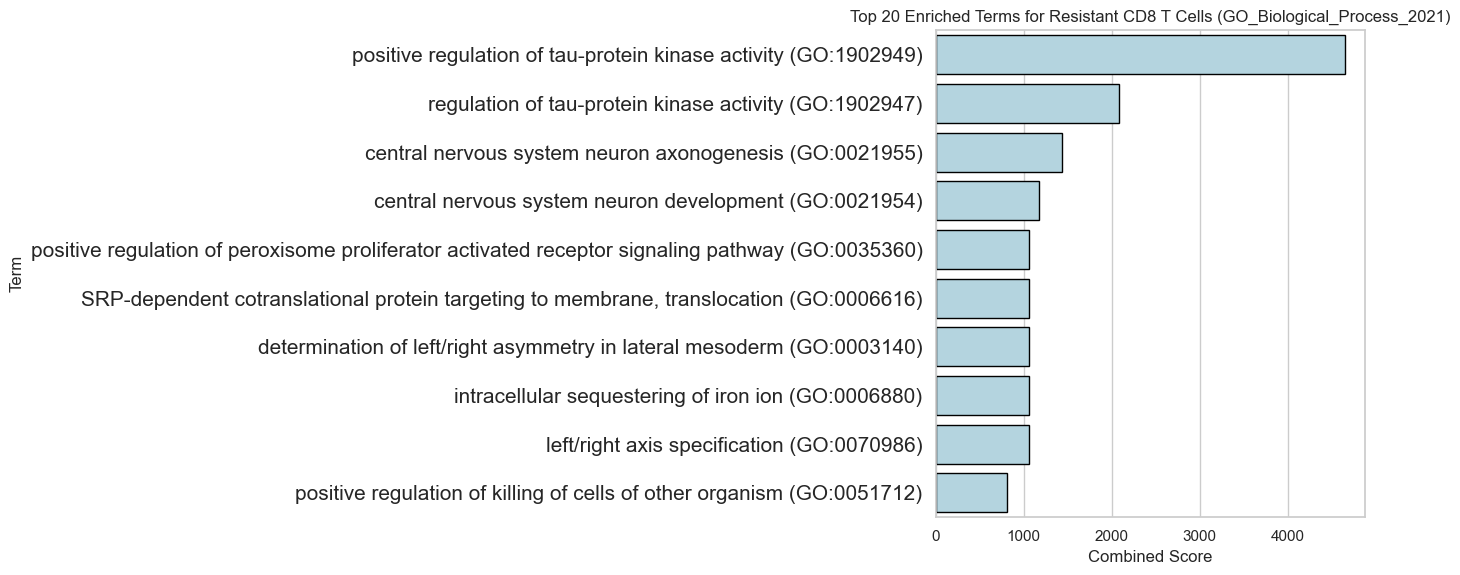

In [46]:

gene_list = top_genes_resist
database = 'GO_Biological_Process_2021'
results_suscep = get_enrichr_results(gene_list, database)
plt.rcParams.update({'font.size': 15})

# results_aff = get_enrichr_results(gene_list, database)
results_suscep.sort_values(by='Combined Score', inplace=True, ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x='Combined Score', y='Term', data=results_suscep.head(10), edgecolor='black', color='lightblue',)
plt.title(f'Top 20 Enriched Terms for Resistant CD8 T Cells ({database})')
plt.yticks(fontsize=15) 
plt.tight_layout()
plt.show()
